<a href="https://colab.research.google.com/github/superbunny38/MachineLearning/blob/main/2022AndrewLectureNotes/Probset1/Prob2/Set1Problem2(c).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as pd
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math
import copy

# (c)

The following three problems will deal with a dataset which we have provided in the following files:

**data/ds3_{train,valid,test}.csv**

Each file contains the following columns: $x_1$, $x_2$, $y$, $t$. As in Problem 1, there is one example per row.
First we will consider the ideal case, where we have access to the true t-labels for training. In src/p02cde_posonly, write a logistic classifier that uses $x_1$ and $x_2$ as input features, and train it using only t-labels (you can ignore the y-labels for this part). Output the trained model's predictions on the test set to the file specified in the code.


## Check data

In [2]:
pd.read_csv('/content/ds3_train.csv').head()

,t,x_1,x_2,y
0,0.0,-1.548319,-2.762987,0
1,0.0,-3.958870,-0.612780,0
2,0.0,-2.276375,0.614934,0
3,0.0,0.556287,-3.931406,0
4,0.0,-1.491000,-2.159297,0


## Util

In [3]:
import matplotlib.pyplot as plt
import numpy as np


def add_intercept(x):
    """Add intercept to matrix x.

    Args:
        x: 2D NumPy array.

    Returns:
        New matrix same as x with 1's in the 0th column.
    """
    new_x = np.zeros((x.shape[0], x.shape[1] + 1), dtype=x.dtype)
    new_x[:, 0] = 1
    new_x[:, 1:] = x

    return new_x


def load_dataset(csv_path, label_col='y', add_intercept=False):
    """Load dataset from a CSV file.

    Args:
         csv_path: Path to CSV file containing dataset.
         label_col: Name of column to use as labels (should be 'y' or 'l').
         add_intercept: Add an intercept entry to x-values.

    Returns:
        xs: Numpy array of x-values (inputs).
        ys: Numpy array of y-values (labels).
    """

    def add_intercept_fn(x):
        global add_intercept
        return add_intercept(x)

    # Validate label_col argument
    allowed_label_cols = ('y', 't')
    if label_col not in allowed_label_cols:
        raise ValueError('Invalid label_col: {} (expected {})'
                         .format(label_col, allowed_label_cols))

    # Load headers
    with open(csv_path, 'r') as csv_fh:
        headers = csv_fh.readline().strip().split(',')

    # Load features and labels
    x_cols = [i for i in range(len(headers)) if headers[i].startswith('x')]
    l_cols = [i for i in range(len(headers)) if headers[i] == label_col]
    inputs = np.loadtxt(csv_path, delimiter=',', skiprows=1, usecols=x_cols)
    labels = np.loadtxt(csv_path, delimiter=',', skiprows=1, usecols=l_cols)

    if inputs.ndim == 1:
        inputs = np.expand_dims(inputs, -1)

    if add_intercept:
        inputs = add_intercept_fn(inputs)

    return inputs, labels


def plot(x, y, theta, save_path=None, correction=1.0):
    """Plot dataset and fitted logistic regression parameters.
    Args:
        x: Matrix of training examples, one per row.
        y: Vector of labels in {0, 1}.
        theta: Vector of parameters for logistic regression model.
        save_path: Path to save the plot.
        correction: Correction factor to apply (Problem 2(e) only).
    """
    # Plot dataset
    plt.figure()
    plt.plot(x[y == 1, -2], x[y == 1, -1], 'bx', linewidth=2)
    plt.plot(x[y == 0, -2], x[y == 0, -1], 'go', linewidth=2)

    # Plot decision boundary (found by solving for theta^T x = 0)
    margin1 = (max(x[:, -2]) - min(x[:, -2]))*0.2
    margin2 = (max(x[:, -1]) - min(x[:, -1]))*0.2
    x1 = np.arange(min(x[:, -2])-margin1, max(x[:, -2])+margin1, 0.01)
    x2 = -(theta[0] / theta[2] * correction + theta[1] / theta[2] * x1)
    plt.plot(x1, x2, c='red', linewidth=2)
    plt.xlim(x[:, -2].min()-margin1, x[:, -2].max()+margin1)
    plt.ylim(x[:, -1].min()-margin2, x[:, -1].max()+margin2)

    # Add labels and save to disk
    plt.xlabel('x1')
    plt.ylabel('x2')
    if save_path is not None:
        plt.savefig(save_path)

In [4]:
def sigmoid(theta, x):
  theta_t = np.transpose(theta)
  z = np.dot(theta_t,x)
  result = 1/(1+np.exp(-z))
  return result

In [5]:
def criterion(h,y):#h: pred, y: actual
  assert len(h) == len(y)
  m = len(h)
  loss = 0.
  for i in range(m):
    loss += -y[i]*math.log(h[i])-(1.-y[i])*math.log(1.-h[i])#BCE
  #print("sum of loss:",loss)
  loss = loss/m
  return loss

In [6]:
def acc(h,y):
  as_labels = []
  for _ in h:
    if _ > 0.5:
      as_labels.append(1.)
    elif _ <= 0.5:
      as_labels.append(0.)
  as_labels, y = np.array(as_labels), np.array(y)
  #print(as_labels)
  return (as_labels == y).sum()/len(as_labels)

In [7]:
def check_convergence(previous_theta, new_theta):
  eps=1e-5
  dists = []
  for p, n in zip(previous_theta, new_theta):
    dists.append(abs(p-n))
  diff = np.mean(dists)
  print(f"difference between thetas: {diff}")
  if diff < eps:
    return True
  else:
    return False

In [8]:
#linear model
class LinearModel(object):
    """Base class for linear models."""

    def __init__(self, step_size=0.2, max_iter=100, eps=1e-5,
                 theta_0=[0.,0.,0.], verbose=True):
        """
        Args:
            step_size: Step size for iterative solvers only.
            max_iter: Maximum number of iterations for the solver.
            eps: Threshold for determining convergence.
            theta_0: Initial guess for theta. If None, use the zero vector.
            verbose: Print loss values during training.
        """
        self.theta = theta_0
        self.step_size = step_size
        self.max_iter = max_iter
        self.eps = eps
        self.verbose = verbose

    def fit(self, x, y):
        """Run solver to fit linear model.

        Args:
            x: Training example inputs. Shape (m, n).
            y: Training example labels. Shape (m,).
        """
        assert x.shape[0] ==  y.shape[0]
        

        ###### Find inverse of Hessian
        #derivative of sigmoid
        
        prev_theta = copy.deepcopy(self.theta)
        
        m = x.shape[0]
        Hessians = []
        for j in range(3):
          tmp_H = []
          for k in range(3):
            result_ = 0.
            for i in range(m):
              g = sigmoid(theta = self.theta, x = x[i])
              result_ += g*(1-g)*x[i][j]*x[i][k]
            result_ = result_/m
            tmp_H.append(result_)
          Hessians.append(tmp_H)
        inverse_H = np.linalg.inv(Hessians)
        #print(inverse_H)
        
        ###### Partial derivatives of l(theta) with respect to the theta's
        i,j = 0,0
        partial_d = []#partial d for x_0, x_1, x_2
        for j in range(3):#for all features
          tmp_d = 0. # save partial derivative for each feature
          for i in range(m):
            tmp_d += x[i][j]*(y[i]-sigmoid(theta = self.theta, x = x[i]))
          tmp_d = tmp_d/m
          partial_d.append(tmp_d)
        assert len(partial_d) == x.shape[1]
        #partial_d = np.array(partial_d).reshape(-1,1)
        #print("inverse of Hessian:\n", inverse_H)
        #print("\n\npartial deriv:\n", partial_d)

        update_ = np.matmul(inverse_H, partial_d)

        #calculate loss
        preds = self.predict(x)
        #print("predicted: ",preds[0])
        #print("preds:",preds, "y:",y)
        #print("types:",type(preds), type(y))
        train_loss = criterion(preds, list(y))
        print("train loss: ", train_loss)
        train_acc = acc(preds, list(y))
        print("train acc: ", train_acc)
        #check convergence
        #print("prev:",prev_theta, "new:",update_)
        self.theta = self.theta + update_
        if check_convergence(prev_theta, self.theta) == True:
          print(f"Weights converged. (theta: {self.theta}")
          return True
        return False
        #print(update_)
        #raise NotImplementedError('Subclass of LinearModel must implement fit method.')

    def predict(self, x):
        """Make a prediction given new inputs x.

        Args:
            x: Inputs of shape (m, n).

        Returns:
            Outputs of shape (m,).
        """
        preds = []
        for sample in x:
          #1/(1+np.exp(-z))
          pred = sigmoid(self.theta, sample)
          preds.append(pred)
        return preds
        #raise NotImplementedError('Subclass of LinearModel must implement predict method.')

In [9]:
class LogisticRegression(LinearModel):
    """Logistic regression with Newton's Method as the solver.

    Example usage:
        > clf = LogisticRegression()
        > clf.fit(x_train, y_train)
        > clf.predict(x_eval)
    """
    def __init__(self):
      self.model = LinearModel()

    def fit(self, x, y):
        """Run Newton's Method to minimize J(theta) for logistic regression.

        Args:
            x: Training example inputs. Shape (m, n).
            y: Training example labels. Shape (m,).
        """
      
        # *** START CODE HERE ***
        #model = LinearModel()
        model = self.model
        i = 0
        iter = 10
        while i<iter:#True:
          print(f"epoch: {i}")
          check_conv = model.fit(x,y)
          if check_conv == True:
            break
          i += 1
        # *** END CODE HERE ***

    def predict(self, x):
        """Make a prediction given new inputs x.

        Args:
            x: Inputs of shape (m, n).

        Returns:
            Outputs of shape (m,).
        """
        # *** START CODE HERE ***
        return self.model.predict(x)
        # *** END CODE HERE ***

In [10]:
def save_df(x=None,y=None,pred = None, name = None):
  print(f"Saving df for {name}.csv")
  df = pd.DataFrame({'y':y, 'pred':pred})
  df.to_csv(f'{name}.csv', index = False)

## Main

In [11]:
import numpy as np

# Character to replace with sub-problem letter in plot_path/pred_path
WILDCARD = 'X'


def main(train_path = '/content/ds3_train.csv', valid_path = '/content/ds3_valid.csv', test_path = '/content/ds3_test.csv', pred_path = WILDCARD):
    """Problem 2: Logistic regression for incomplete, positive-only labels.

    Run under the following conditions:
        1. on y-labels,
        2. on l-labels,
        3. on l-labels with correction factor alpha.

    Args:
        train_path: Path to CSV file containing training set.
        valid_path: Path to CSV file containing validation set.
        test_path: Path to CSV file containing test set.
        pred_path: Path to save predictions.
    """
    pred_path_c = pred_path.replace(WILDCARD, 'c')
    pred_path_d = pred_path.replace(WILDCARD, 'd')
    pred_path_e = pred_path.replace(WILDCARD, 'e')

    # *** START CODE HERE ***
    # Part (c): Train and test on true labels
    x_train, y_train = load_dataset(train_path, add_intercept=True,label_col='t')
    print(f"train dataset loaded (x with intercept on 0th col: {x_train.shape}, y: {y_train.shape})")
    
    print("================Training Starts===========\n")
    clf = LogisticRegression()
    clf.fit(x_train, y_train)
    pred_train = clf.predict(x_train)
    save_df(x_train, y_train, pred_train, "train_pred")
    train_loss = criterion(pred_train, y_train)
    train_acc = acc(pred_train, y_train)
    print(f"train loss: {train_loss} train acc: {train_acc}")
    
    #x_val, y_val = load_dataset(eval_path, add_intercept=True)
  
    #print(f"validation dataset loaded (x with intercept on 0th col: {x_val.shape}, y: {y_val.shape})")
    
    #pred_val = clf.predict(x_val)
    #val_loss = criterion(pred_val, y_val)
    #val_acc = acc(pred_val, y_val)
    #count = 0
    #print("validation loss:",val_loss)
    #print("validation acc:",val_acc)

    # Make sure to save outputs to pred_path_c
    # Part (d): Train on y-labels and test on true labels
    # Make sure to save outputs to pred_path_d
    # Part (e): Apply correction factor using validation set and test on true labels
    # Plot and use np.savetxt to save outputs to pred_path_e
    # *** END CODER HERE

In [12]:
main()

train dataset loaded (x with intercept on 0th col: (1250, 3), y: (1250,))
================Training Starts===========

epoch: 0
train loss:  0.6931471805599237
train acc:  0.5
difference between thetas: 0.3268090556662272
epoch: 1
train loss:  0.255272108113938
train acc:  0.9552
difference between thetas: 0.2323814169921219
epoch: 2
train loss:  0.15492611782407203
train acc:  0.9632
difference between thetas: 0.29136367521747863
epoch: 3
train loss:  0.1127160024053409
train acc:  0.9648
difference between thetas: 0.3384278087569869
epoch: 4
train loss:  0.09573371248599
train acc:  0.9632
difference between thetas: 0.3081662109616556
epoch: 5
train loss:  0.09075960580492828
train acc:  0.964
difference between thetas: 0.16373867007892803
epoch: 6
train loss:  0.09011278765745298
train acc:  0.9632
difference between thetas: 0.030653440202831488
epoch: 7
train loss:  0.09009745294842639
train acc:  0.9632
difference between thetas: 0.0008493323185674676
epoch: 8
train loss:  0.090097

# (d)

We now consider the case where the t-labels are unavailable, so you only have access to the y-labels at training time. Add to your code in p02cde_posonly.py to re-train the classifier (still using x1 and x2 as input features), but using the y-labels only.

In [13]:
import numpy as np

# Character to replace with sub-problem letter in plot_path/pred_path
WILDCARD = 'X'


def main(train_path = '/content/ds3_train.csv', valid_path = '/content/ds3_valid.csv', test_path = '/content/ds3_test.csv', pred_path = WILDCARD):
    """Problem 2: Logistic regression for incomplete, positive-only labels.

    Run under the following conditions:
        1. on y-labels,
        2. on l-labels,
        3. on l-labels with correction factor alpha.

    Args:
        train_path: Path to CSV file containing training set.
        valid_path: Path to CSV file containing validation set.
        test_path: Path to CSV file containing test set.
        pred_path: Path to save predictions.
    """
    pred_path_c = pred_path.replace(WILDCARD, 'c')
    pred_path_d = pred_path.replace(WILDCARD, 'd')
    pred_path_e = pred_path.replace(WILDCARD, 'e')

    # *** START CODE HERE ***
    # Part (c): Train and test on true labels
    x_train, y_train = load_dataset(train_path, add_intercept=True,label_col='y')
    print(f"train dataset loaded (x with intercept on 0th col: {x_train.shape}, y: {y_train.shape})")
    
    print("================Training Starts===========\n")
    clf = LogisticRegression()
    clf.fit(x_train, y_train)
    pred_train = clf.predict(x_train)
    save_df(x_train, y_train, pred_train, "train_pred")
    train_loss = criterion(pred_train, y_train)
    train_acc = acc(pred_train, y_train)
    print(f"train loss: {train_loss} train acc: {train_acc}")
    
    #x_val, y_val = load_dataset(eval_path, add_intercept=True)
  
    #print(f"validation dataset loaded (x with intercept on 0th col: {x_val.shape}, y: {y_val.shape})")
    
    #pred_val = clf.predict(x_val)
    #val_loss = criterion(pred_val, y_val)
    #val_acc = acc(pred_val, y_val)
    #count = 0
    #print("validation loss:",val_loss)
    #print("validation acc:",val_acc)

    # Make sure to save outputs to pred_path_c
    # Part (d): Train on y-labels and test on true labels
    # Make sure to save outputs to pred_path_d
    # Part (e): Apply correction factor using validation set and test on true labels
    # Plot and use np.savetxt to save outputs to pred_path_e
    # *** END CODER HERE

In [14]:
main()

train dataset loaded (x with intercept on 0th col: (1250, 3), y: (1250,))
================Training Starts===========

epoch: 0
train loss:  0.6931471805599237
train acc:  0.9
difference between thetas: 0.5780482145838554
epoch: 1
train loss:  0.32260270056700235
train acc:  0.9
difference between thetas: 0.2628969567477062
epoch: 2
train loss:  0.2841524262392598
train acc:  0.9
difference between thetas: 0.2037460669210164
epoch: 3
train loss:  0.2734972734514839
train acc:  0.9
difference between thetas: 0.16129991718263825
epoch: 4
train loss:  0.2710017842758052
train acc:  0.9
difference between thetas: 0.06779004829961162
epoch: 5
train loss:  0.2707750864018856
train acc:  0.9
difference between thetas: 0.00791566078970285
epoch: 6
train loss:  0.27077265581631893
train acc:  0.9
difference between thetas: 9.156480654976447e-05
epoch: 7
train loss:  0.2707726554967858
train acc:  0.9
difference between thetas: 1.2127764699905915e-08
Weights converged. (theta: [-2.91607454  0.785

# (e)
Using the validation set, estimate the constant $α$ by averaging your classifier's predictions over all labeled examples in the validation set

$$\alpha ≈ \frac{1}{|V+|}\sum_{x^{(i)} ∈ V_+}h(x^{(i)})$$

Add code in src/p02cde_posonly.py to rescale your classifier's predictions from part (d) using the estimated value for $α$.

Finally, using a threshold of $p(t^{(i)} = 1|x^{(i)}) = 0.5$, make three separate plots with the decision boundaries from parts (c) - (e) plotted on the top of the test set. Plot $x_1$ on the horizontal axis and $x_2$ on the vertical axis, and use two different symbols for the positive $(t^{(i)} = 1)$ and negative $(t^{(i)} = 0)$ examples. In each plot, indicate the separating hyperplane with a red line.

## $ h(x^{(i)})$
$ h(x^{(i)}) ≈ \alpha = p(y^{(i)} = 1 | x^{(i)})$ for all $x \in V_{+}$

In [15]:
#check validation data
pd.read_csv('ds3_valid.csv').head()

,t,x_1,x_2,y
0,0.0,-3.045520,-1.857371,0
1,0.0,-3.998597,0.368850,0
2,0.0,-4.789953,-0.689660,0
3,0.0,-3.596480,-2.434832,0
4,0.0,-1.830972,-3.134346,0


In [63]:
import numpy as np

# Character to replace with sub-problem letter in plot_path/pred_path
WILDCARD = 'X'


def main(train_path = '/content/ds3_train.csv', valid_path = '/content/ds3_valid.csv', test_path = '/content/ds3_test.csv', pred_path = WILDCARD):
    """Problem 2: Logistic regression for incomplete, positive-only labels.

    Run under the following conditions:
        1. on y-labels,
        2. on l-labels,
        3. on l-labels with correction factor alpha.

    Args:
        train_path: Path to CSV file containing training set.
        valid_path: Path to CSV file containing validation set.
        test_path: Path to CSV file containing test set.
        pred_path: Path to save predictions.
    """
    pred_path_c = pred_path.replace(WILDCARD, 'c')
    pred_path_d = pred_path.replace(WILDCARD, 'd')
    pred_path_e = pred_path.replace(WILDCARD, 'e')

    # *** START CODE HERE ***
    # Part (c): Train and test on true labels
    x_train, y_train = load_dataset(train_path, add_intercept=True,label_col='y')
    print(f"train dataset loaded (x with intercept on 0th col: {x_train.shape}, y: {y_train.shape})")
    
    print("================Training Starts===========\n")
    clf = LogisticRegression()
    clf.fit(x_train, y_train)
    pred_train = clf.predict(x_train)
    save_df(x_train, y_train, pred_train, "train_pred")
    train_loss = criterion(pred_train, y_train)
    train_acc = acc(pred_train, y_train)
    print(f"train loss: {train_loss} train acc: {train_acc}")

    print("================Validation=============\n")
    x_val, y_val = load_dataset(valid_path, add_intercept=True, label_col='y')
  
    print(f"validation dataset loaded (x with intercept on 0th col: {x_val.shape}, y: {y_val.shape})")
    
    pred_val = clf.predict(x_val)
    # val_loss = criterion(pred_val, y_val)
    # val_acc = acc(pred_val, y_val)
    # print("validation loss:",val_loss)
    # print("validation acc:",val_acc)
    return pred_val, clf
    # Make sure to save outputs to pred_path_c
    # Part (d): Train on y-labels and test on true labels
    # Make sure to save outputs to pred_path_d
    # Part (e): Apply correction factor using validation set and test on true labels
    # Plot and use np.savetxt to save outputs to pred_path_e
    # *** END CODER HERE

In [64]:
pred_val, clf = main()

train dataset loaded (x with intercept on 0th col: (1250, 3), y: (1250,))
================Training Starts===========

epoch: 0
train loss:  0.6931471805599237
train acc:  0.9
difference between thetas: 0.5780482145838554
epoch: 1
train loss:  0.32260270056700235
train acc:  0.9
difference between thetas: 0.2628969567477062
epoch: 2
train loss:  0.2841524262392598
train acc:  0.9
difference between thetas: 0.2037460669210164
epoch: 3
train loss:  0.2734972734514839
train acc:  0.9
difference between thetas: 0.16129991718263825
epoch: 4
train loss:  0.2710017842758052
train acc:  0.9
difference between thetas: 0.06779004829961162
epoch: 5
train loss:  0.2707750864018856
train acc:  0.9
difference between thetas: 0.00791566078970285
epoch: 6
train loss:  0.27077265581631893
train acc:  0.9
difference between thetas: 9.156480654976447e-05
epoch: 7
train loss:  0.2707726554967858
train acc:  0.9
difference between thetas: 1.2127764699905915e-08
Weights converged. (theta: [-2.91607454  0.785

## estimate the constant $\alpha$ by averaging your classifier's predictions over all labeled examples in the validation set

In [65]:
alpha = np.mean(pred_val)#the average probability of given x being labeled

In [66]:
alpha

0.10093150508835273

## add code to rescale your classifier's predictions from part (d) using the estimated value for $α$

$p(t^{(i)}=1|x^{(i)}) = p(y^{(i)}=1|x^{(i)})/α$

In [48]:
def criterion(h,y):#h: pred, y: actual
  assert len(h) == len(y)
  m = len(h)
  loss = 0.
  for i in range(m):
    if h[i] == 0.:
      print("h: ",h[i])
    loss += -y[i]*math.log(h[i])-(1.-y[i])*math.log(1.-h[i])#BCE
  #print("sum of loss:",loss)
  loss = loss/m
  return loss

In [98]:
import numpy as np

# Character to replace with sub-problem letter in plot_path/pred_path
WILDCARD = 'X'

def main(train_path = '/content/ds3_train.csv', valid_path = '/content/ds3_valid.csv', test_path = '/content/ds3_test.csv', pred_path = WILDCARD, alpha = alpha):
    """Problem 2: Logistic regression for incomplete, positive-only labels.

    Run under the following conditions:
        1. on y-labels,
        2. on l-labels,
        3. on l-labels with correction factor alpha.

    Args:
        train_path: Path to CSV file containing training set.
        valid_path: Path to CSV file containing validation set.
        test_path: Path to CSV file containing test set.
        pred_path: Path to save predictions.
    """
    pred_path_c = pred_path.replace(WILDCARD, 'c')
    pred_path_d = pred_path.replace(WILDCARD, 'd')
    pred_path_e = pred_path.replace(WILDCARD, 'e')

    # *** START CODE HERE ***
    # Part (c): Train and test on true labels
    x_train, y_train = load_dataset(train_path, add_intercept=True,label_col='y')
    print(f"train dataset loaded (x with intercept on 0th col: {x_train.shape}, y: {y_train.shape})")
    
    print("================Training Starts===========\n")
    clf = LogisticRegression()
    # print(type(y_train))
    rescaled_y = [y/alpha for y in y_train]
    rescaled_y = np.array(rescaled_y)
    clf.fit(x_train, rescaled_y)
    # pred_train = clf.predict(x_train)
    # save_df(x_train, y_train, pred_train, "train_pred")
    # train_loss = criterion(pred_train, y_train)
    # train_acc = acc(pred_train, y_train)
    # print(f"Original train loss: {train_loss} train acc: {train_acc}")
    
    # rescaled_pred_train = [x/alpha for x in pred_train]
    # save_df(x_train, y_train, rescaled_pred_train, "rescaled_train_pred")
    # #rescaled_train_loss = criterion(rescaled_pred_train, y_train)
    # rescaled_train_acc = acc(rescaled_pred_train, y_train)
    # print(f"recaled train acc: {rescaled_train_acc}")
    # #print(f"validation dataset loaded (x with intercept on 0th col: {x_val.shape}, y: {y_val.shape})")
    
    # return pred_train, rescaled_pred_train, clf
    #val_loss = criterion(pred_val, y_val)
    #val_acc = acc(pred_val, y_val)
    #count = 0
    #print("validation loss:",val_loss)
    #print("validation acc:",val_acc)

    # Make sure to save outputs to pred_path_c
    # Part (d): Train on y-labels and test on true labels
    # Make sure to save outputs to pred_path_d
    # Part (e): Apply correction factor using validation set and test on true labels
    # Plot and use np.savetxt to save outputs to pred_path_e
    # *** END CODE HERE

In [99]:
main()

train dataset loaded (x with intercept on 0th col: (1250, 3), y: (1250,))
================Training Starts===========

epoch: 0
train loss:  0.6931471805599237
train acc:  0.9
difference between thetas: 1.2948720229616593
epoch: 1
train loss:  -2.028279075509343
train acc:  0.3432
difference between thetas: 15.586964859383135
epoch: 2


ValueError: ignored

## Using a threshold of $p(t^{(i)} = 1|x^{(i)})$ = 0.5, make three separate plots with the decision boundaries from parts (c) - (e) plotted on top of the test set. Plot $x_1$ on the horizontal axis and $x_2$ on the vertical axis, and use two different symbols for the positive $(t^{(i)} = 1)$ and negative $(t^{(i)} = 0)$ examples. In each plot indicate the seaparating hyperplane with a red line

### (c)

In [77]:
x_test, y_test = load_dataset('/content/ds3_test.csv', add_intercept=True,label_col='t')

In [79]:
c_thetas = [-0.9711418,2.73208784,1.07403478]

In [82]:
def plot(x, y, theta, save_path=None, correction=1.0, title = ""):
    """Plot dataset and fitted logistic regression parameters.
    Args:
        x: Matrix of training examples, one per row.
        y: Vector of labels in {0, 1}.
        theta: Vector of parameters for logistic regression model.
        save_path: Path to save the plot.
        correction: Correction factor to apply (Problem 2(e) only).
    """
    # Plot dataset
    plt.figure()
    plt.title(title)
    plt.plot(x[y == 1, -2], x[y == 1, -1], 'bx', linewidth=2)
    plt.plot(x[y == 0, -2], x[y == 0, -1], 'go', linewidth=2)

    # Plot decision boundary (found by solving for theta^T x = 0)
    margin1 = (max(x[:, -2]) - min(x[:, -2]))*0.2
    margin2 = (max(x[:, -1]) - min(x[:, -1]))*0.2
    
    x1 = np.arange(min(x[:, -2])-margin1, max(x[:, -2])+margin1, 0.01)
    x2 = -(theta[0] / theta[2] * correction + theta[1] / theta[2] * x1)
    plt.plot(x1, x2, c='red', linewidth=2)
    plt.xlim(x[:, -2].min()-margin1, x[:, -2].max()+margin1)
    plt.ylim(x[:, -1].min()-margin2, x[:, -1].max()+margin2)

    # Add labels and save to disk
    plt.xlabel('x1')
    plt.ylabel('x2')
    if save_path is not None:
        plt.savefig(save_path)

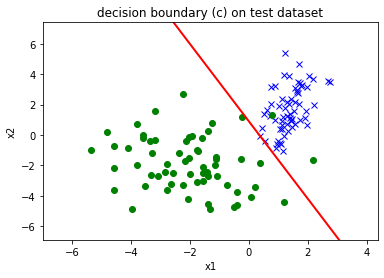

In [85]:
plot(x_test, y_test, c_thetas, title = "decision boundary (c) on test dataset")

### (d)

In [84]:
d_thetas = [-2.91607454,0.78596651,0.09282768]

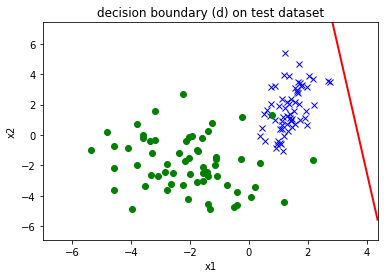

In [86]:
plot(x_test, y_test, d_thetas, title = "decision boundary (d) on test dataset")

### (e)

In [87]:
e_thetas = [-2.91607454,0.78596651, 0.09282768]

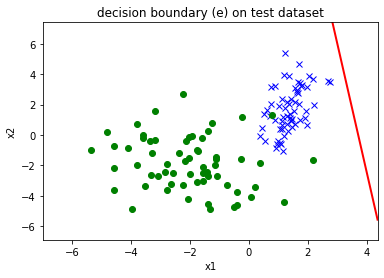

In [88]:
plot(x_test, y_test, e_thetas, title = "decision boundary (e) on test dataset")